In [78]:
import os
import pandas as pd
import numpy as np
import pandas_gbq
import unidecode
import requests

In [79]:
from google.cloud import bigquery

In [80]:
from dotenv import load_dotenv
load_dotenv('/Users/daniel/OAN/credentials/contoan/.env')

True

In [81]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print(__version__) # requires version >= 1.9.0

4.9.0


In [82]:
import cufflinks as cf

In [83]:
init_notebook_mode(connected=True)

In [84]:
cf.go_offline()

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

### ANALYCEMOS CUENTAS

In [86]:
sql = """
   SELECT acc.id as `ID`,
       acc.creation_date as `CREACION`,
       acc.execution_date as `EJECUCION`,
       acc.concept as `CONCEPTO`,
       pr.name as `PROJECTO`,
       int.name as `INTERVENCION`,
       ph.name as `FASE`,
       CASE 
        WHEN acc.type = 'expense'  THEN 'Gasto'
        WHEN acc.type = 'income'  THEN 'Ingreso'
        WHEN acc.type = 'movement'  THEN 'Movimiento'
        ELSE ''
      END AS `TIPO`,
       acc.amount as `CANTIDAD`,
       acc.vat as `IVA`,
       acc.vat_amount as `IVA_CTA`,
       tg.name as `CAJA_BANCO`,
       ac.name as `CATEGORIA`,
       acc.description as `DESCRIPCION`,
       cr.name as `CREADOR`,
       rs.name as `RESPONSABLE`,      
       acc.code as `COTADOR`,
       acc.origin as `ORIGEN`,
       acc.place as `LUGAR`,
       acc.receipt as `FACTURA`
       
      
FROM `oan-nikarit.contoan.accounting` acc
LEFT OUTER JOIN `oan-nikarit.contoan.accounts` ac
ON acc.account_id = ac.id
LEFT OUTER JOIN `oan-nikarit.contoan.accounts` tg
ON acc.target_id = tg.id
LEFT OUTER JOIN `oan-nikarit.contoan.projects` pr
ON acc.project = pr.id
LEFT OUTER JOIN `oan-nikarit.contoan.projects` int
ON acc.intervention = int.id
LEFT OUTER JOIN `oan-nikarit.contoan.projects` ph
ON acc.phase = ph.id
LEFT OUTER JOIN `oan-nikarit.contoan.users` cr
ON acc.creator_user = cr.id
LEFT OUTER JOIN `oan-nikarit.contoan.users` rs
ON acc.user_in_charge = rs.id
""".lower()

# Run a Standard SQL query using the environment's default project
df = pd.read_gbq(sql, dialect='standard')

Downloading: 100%|██████████| 2403/2403 [00:01<00:00, 1611.59rows/s]


In [87]:
df['projecto'].value_counts()

Nikarit                   1904
Administration_general     209
Pompes d'eau                82
ADSAN                       71
Fassol                      57
Emancipacion                49
Forum Nikki                 17
CPNPF                        6
Aguapp                       4
Évènements                   4
Name: projecto, dtype: int64

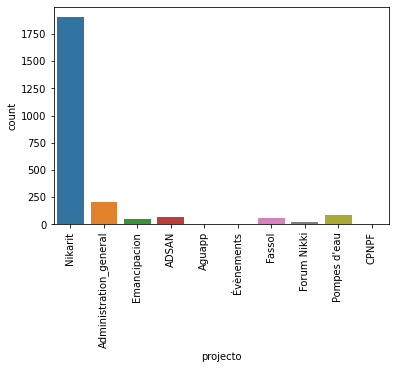

In [88]:
sns.countplot(x='projecto',data=df)
plt.xticks(rotation=90)
plt.show()

In [89]:
df['caja_banco'].value_counts()

Banco Stripe                  1064
Banco Paypal                   401
Banco Caja de Ingenieros       319
Caja Mireille                  182
Banco Santander                140
Caja Kader                      80
Caja Hafiz                      55
Caja Daniel                     37
Caja Abour Rhaman               29
Caja Rasak                      24
Caja Imorou                     14
Caja Chemita                    11
Caja Habirou                    11
Bank of Africa                   7
Caja                             7
Deudas a c.p. (Acreedores)       7
Caja Younous                     5
Deudas a c.p. (Deudores)         4
Caja Jaume                       2
Caja Sofia                       2
Caja Sianson                     1
Caja Angel                       1
Name: caja_banco, dtype: int64

In [90]:
df['origen'].value_counts()

script_dani    903
contoan        710
shopify        654
g_forms        136
Name: origen, dtype: int64

In [91]:
df.groupby(['origen','lugar']).count()['id']

origen       lugar
contoan      benin    247
             spain    463
g_forms      benin    135
             spain      1
script_dani  spain    903
shopify      spain    654
Name: id, dtype: int64

In [92]:
print(df.columns)

Index(['id', 'creacion', 'ejecucion', 'concepto', 'projecto', 'intervencion',
       'fase', 'tipo', 'cantidad', 'iva', 'iva_cta', 'caja_banco', 'categoria',
       'descripcion', 'creador', 'responsable', 'cotador', 'origen', 'lugar',
       'factura'],
      dtype='object')


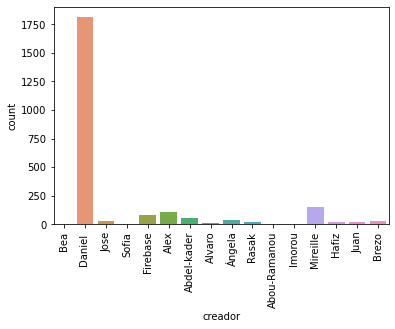

In [93]:
sns.countplot(x='creador',data=df)
plt.xticks(rotation=90)
plt.show()

## NIKARIT

In [94]:
df.columns

Index(['id', 'creacion', 'ejecucion', 'concepto', 'projecto', 'intervencion',
       'fase', 'tipo', 'cantidad', 'iva', 'iva_cta', 'caja_banco', 'categoria',
       'descripcion', 'creador', 'responsable', 'cotador', 'origen', 'lugar',
       'factura'],
      dtype='object')

In [95]:
df_nikarit = df[df['projecto']=='Nikarit']

In [96]:
df_nik_cat=df_nikarit.groupby(['categoria','tipo','intervencion'])['cantidad'].sum().reset_index()

In [97]:
df_nik_cat.head(2)

,categoria,tipo,intervencion,cantidad
0,Alquileres (oficinas y otros),gasto,Espagne General 2020,199.65
1,Apertura,movimiento,Espagne General 2020,12102.71


In [98]:
expense = df_nik_cat[df_nik_cat['tipo']=='gasto']

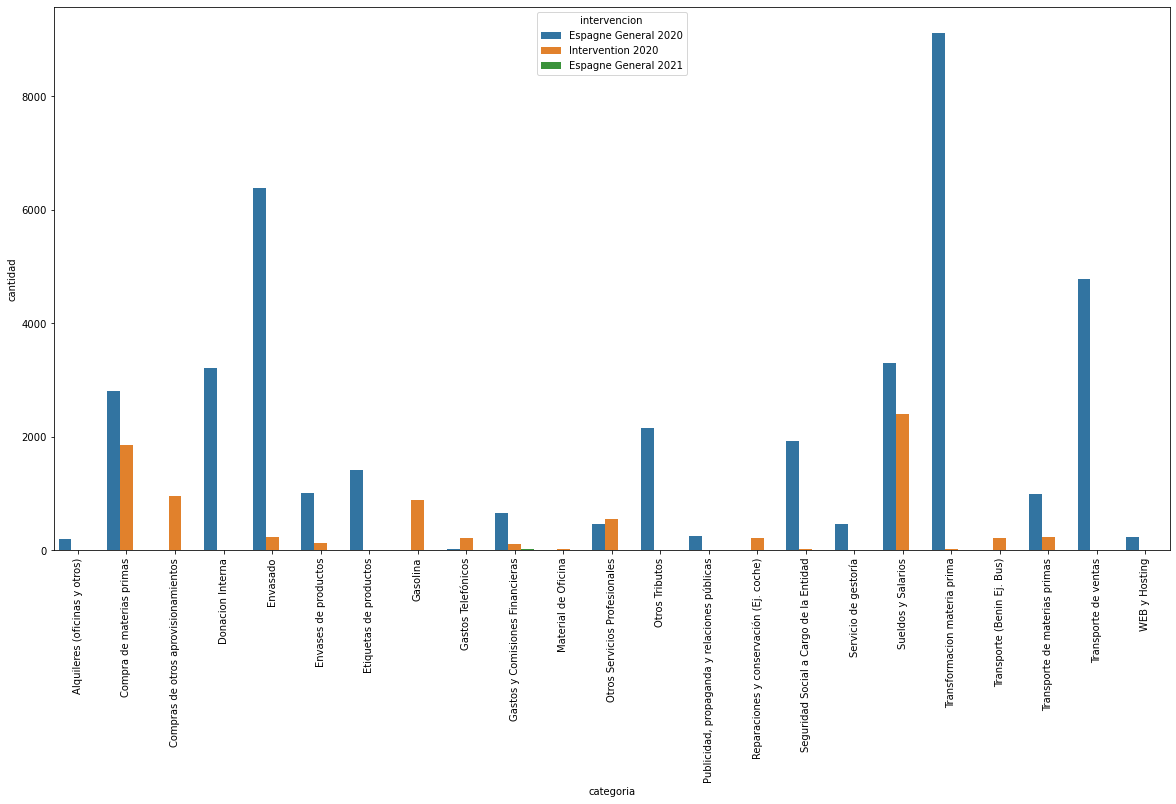

In [99]:
fig = plt.figure(figsize=(20,10))
ax = sns.barplot(x="categoria", y="cantidad",hue='intervencion', data=expense)
plt.xticks(rotation=90)
plt.show()

## INGRESOS Y GASTOS

In [100]:
df_3 = df_nikarit.groupby('tipo')['cantidad'].sum().reset_index()
df_3.head()

,tipo,cantidad
0,gasto,47505.89
1,ingreso,37496.03
2,movimiento,51027.12


In [101]:
df_3.iplot(kind='bar',x='tipo',y='cantidad')

## GASTOS

In [102]:
expense.intervencion.unique()

array(['Espagne General 2020', 'Intervention 2020',
       'Espagne General 2021'], dtype=object)

### NIKKI

In [103]:
expense[expense['intervencion']=='Intervention 2020'
       ]['cantidad'].sum()

8091.379999999999

In [104]:
expense[expense['intervencion']=='Intervention 2020'
       ].sort_values('cantidad',ascending=False)[['categoria','cantidad']]

,categoria,cantidad
38,Sueldos y Salarios,2401.75
8,Compra de materias primas,1863.32
9,Compras de otros aprovisionamientos,965.13
21,Gasolina,889.08
30,Otros Servicios Profesionales,547.54
43,Transporte de materias primas,230.19
17,Envasado,228.66
33,Reparaciones y conservación (Ej. coche),223.32
41,Transporte (Benin Ej. Bus),218.09
23,Gastos Telefónicos,216.27


In [105]:
expense[expense['intervencion']=='Intervention 2020'
       ].sort_values('cantidad',ascending=False
                    ).iplot(kind='bar',x='categoria',
                            y='cantidad',title='GASTOS NIKKI - 3853.75 €')

In [106]:
df_nikarit[(df_nikarit['intervencion']=='Intervention 2020') &
         (df_nikarit['categoria']=='Sueldos y Salarios')
          ][['concepto','cantidad','descripcion','creacion']].sort_values('creacion')


,concepto,cantidad,descripcion,creacion
2315,Salaire / Personnelle,22.83,"Salaire de Younous, Mireille et Lamatou pour l...",2020-02-27 10:24:26+00:00
2317,Salaire / Personnelle,175.05,"Salarios acumulados de Younous, Lamatou y Mire...",2020-03-11 12:36:58+00:00
2316,Salaire / Personnelle,60.89,Salaires del mes de febrero 2020 de Younous y ...,2020-03-11 13:04:54+00:00
2312,Salaire / Personnelle,45.66,"2 visites aux villages nouveaux avec Lamatou, ...",2020-03-17 23:19:42+00:00
2314,Salaire / Personnelle,91.33,Salaire pour voyage dans les villages,2020-04-02 12:17:30+00:00
2313,Salaire / Personnelle,91.33,Salaire mensuel,2020-05-03 16:15:07+00:00
2318,Salaire / Personnelle,53.35,Salaire younouss et lamatou,2020-05-03 16:20:03+00:00
2310,entretien younouss,22.87,entretien de younouss pour voyager dans les vi...,2020-06-19 06:54:26.105000+00:00
2065,salaire younouss,60.98,entretien de younouss du voyage sur parakou po...,2020-06-19 07:36:31.176000+00:00
2306,salaire mireille,121.95,salaire du mois de Mai,2020-06-19 07:52:09.020000+00:00


Salaire / Personnelle	91.33	04-30	Salaire mensuel (ABRIL)
salaire mireille	121.95	06-01	salaire du mois de Mai
alaire mireille	182.93	07-10	salaire du mois de juin
salaire mireille	182.93	07-31	salaire du mois de juillet
Salaire / Personnelle	175.05	12-23	Salarios acumulados de Younous, Lamatou y Mire...


## ESPAÑA

In [107]:
expense[expense['intervencion']=='Espagne General 2020'
       ].sort_values('cantidad',ascending=False)[['categoria','cantidad']]

,categoria,cantidad
39,Transformacion materia prima,9119.77
16,Envasado,6387.36
44,Transporte de ventas,4783.80
37,Sueldos y Salarios,3296.18
13,Donacion Interna,3212.69
7,Compra de materias primas,2800.06
31,Otros Tributos,2149.46
34,Seguridad Social a Cargo de la Entidad,1930.91
20,Etiquetas de productos,1418.63
18,Envases de productos,1003.24


In [108]:
expense[expense['intervencion']=='Espagne General 2020']['cantidad'].sum()

39396.22

In [109]:
expense[expense['intervencion']=='Espagne General 2020'
       ].sort_values('cantidad',ascending=False
                    ).iplot(kind='bar',x='categoria',y='cantidad',title='Gastos Totales 21,909€'
                           )

In [110]:
df_nik_cat.categoria.unique()

array(['Alquileres (oficinas y otros)', 'Apertura',
       'Banco Caja de Ingenieros', 'Banco Paypal', 'Banco Santander',
       'Banco Stripe', 'Caja', 'Compra de materias primas',
       'Compras de otros aprovisionamientos',
       'Deudas a c.p. (Acreedores)', 'Deudas gastos de envio',
       'Donacion Interna', 'Donaciones', 'Envasado',
       'Envases de productos', 'Etiquetas de productos', 'Gasolina',
       'Gastos Telefónicos', 'Gastos y Comisiones Financieras',
       'Material de Oficina', 'Otros Servicios Profesionales',
       'Otros Tributos', 'Publicidad, propaganda y relaciones públicas',
       'Reparaciones y conservación (Ej. coche)',
       'Seguridad Social a Cargo de la Entidad', 'Servicio de gestoría',
       'Sueldos y Salarios', 'Transformacion materia prima',
       'Transporte (Benin Ej. Bus)', 'Transporte de materias primas',
       'Transporte de ventas', 'Venta de Manteca de Karite',
       'WEB y Hosting'], dtype=object)

### ANALIZAR COMISIONES

In [111]:
df2=df_nikarit[(df_nikarit['intervencion']=='Espagne General 2020')&
                (df_nikarit['origen'] !='contoan' )].groupby('categoria')['cantidad'].sum().reset_index()

In [112]:
#Ingresos shopify
df2[df2['categoria']=='Venta de Manteca de Karite']['cantidad'].values[0]

19744.329999999973

In [113]:
#Comisiones pagos en shopify
df2[df2['categoria']=='Gastos y Comisiones Financieras']['cantidad'].values[0]

590.9099999999999

In [114]:
#Ratio de comision
100*(df2[df2['categoria']=='Gastos y Comisiones Financieras']['cantidad'].values[0]
 /df2[df2['categoria']=='Venta de Manteca de Karite']['cantidad'].values[0])

2.992808568333292

In [115]:
df_nikarit['categoria'].unique()

array(['Venta de Manteca de Karite', 'Donaciones', 'Banco Stripe',
       'Apertura', 'Gastos y Comisiones Financieras',
       'Deudas gastos de envio', 'Caja', 'Banco Caja de Ingenieros',
       'Deudas a c.p. (Acreedores)', 'Banco Santander', 'Banco Paypal',
       'Donacion Interna', 'Otros Tributos', 'Gasolina',
       'Reparaciones y conservación (Ej. coche)',
       'Compra de materias primas', 'Transporte de materias primas',
       'Sueldos y Salarios', 'Compras de otros aprovisionamientos',
       'Seguridad Social a Cargo de la Entidad', 'Material de Oficina',
       'Transporte (Benin Ej. Bus)', 'Gastos Telefónicos',
       'Otros Servicios Profesionales', 'WEB y Hosting',
       'Transporte de ventas',
       'Publicidad, propaganda y relaciones públicas',
       'Servicio de gestoría', 'Envasado', 'Envases de productos',
       'Etiquetas de productos', 'Alquileres (oficinas y otros)',
       'Transformacion materia prima'], dtype=object)

In [116]:
df_nikarit[(df_nikarit['intervencion']=='Intervention 2020') &
         (df_nikarit['categoria']=='Compras de otros aprovisionamientos')
          ][['concepto','cantidad','creacion','descripcion']].sort_values('creacion')

,concepto,cantidad,creacion,descripcion
2308,Achat de materiaux,45.66,2020-02-26 22:58:25+00:00,Achat d'une bascul de maximum 100 kilos pour p...
2067,Achat de materiaux,45.66,2020-02-26 23:06:58+00:00,Achat piece pour reparation moulin Bessen Gourou
2401,Achat de materiaux,24.35,2020-02-29 15:48:56+00:00,Achat de 10 metres de tissus a 6.000 F le tota...
2307,Carte d'identité,4.57,2020-03-11 12:59:18+00:00,Carte d'identité
2399,Achat de materiaux,38.97,2020-03-11 20:32:07+00:00,Compra de 12 metros de tela en el mercado a 72...
2398,Achat de materiaux,49.47,2020-03-12 14:49:57+00:00,Compra de 56 metros de tela para el pedido de ...
2400,Achat de materiaux,96.12,2020-03-17 23:24:14+00:00,Couture 421 petits sacs chez Kasim
2309,Achat de materiaux,27.40,2020-05-04 08:43:15+00:00,Achat de pneu
2072,achat matériels des femmes,334.15,2020-06-27 08:24:40.552000+00:00,achat des sacs pour emballer les amandes de ka...
2064,achats de gants,68.60,2020-08-10 11:16:16.321000+00:00,achats de gants pour les femmes de monnon


## ventas

In [117]:
sql = """
    SELECT *
    FROM `oan-nikarit.contoan.sales`
"""

# Run a Standard SQL query using the environment's default project
df_ventas = pd.read_gbq(sql, dialect='standard')

Downloading: 100%|██████████| 865/865 [00:01<00:00, 514.77rows/s]


In [118]:
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865 entries, 0 to 864
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   latitude                 755 non-null    float64            
 1   country                  778 non-null    object             
 2   packHidra_unit_price     861 non-null    float64            
 3   packContigo_total_price  861 non-null    float64            
 4   manteca_total_price      863 non-null    float64            
 5   total_tax                865 non-null    float64            
 6   longitude                755 non-null    float64            
 7   client_gender            865 non-null    object             
 8   client_last_name         855 non-null    object             
 9   product_movement         215 non-null    object             
 10  order_id                 865 non-null    object             
 11  accounting_item          227 non

In [119]:
df_ventas=df_ventas.sort_values('creation_date',
                                ascending=True).reset_index(drop=True)

In [120]:
(100*df_ventas['province'].value_counts()/537)[0:10]

Madrid        80.074488
Barcelona      8.379888
Valladolid     7.821229
Valencia       5.586592
Málaga         4.096834
A Coruña       3.165736
Cantabria      2.979516
Asturias       2.793296
Granada        2.607076
Sevilla        2.234637
Name: province, dtype: float64

In [121]:
df_ventas_shopi = df_ventas[df_ventas['origin']=='Shopify'].reset_index(drop=True)

In [122]:
shop_url = os.environ['SHOPIFY_ACCESS_URL']
dates = ['2019-01-01T00:15:47-04:00','2020-01-01T00:15:47-04:00',
         '2020-05-01T00:15:47-04:00','2020-12-10T00:15:47-04:00', '2021-01-10T00:15:47-04:00']
l_orders = []

for date_min,date_max in zip(dates[:-1],dates[1:]):
    orders_url = shop_url+'/orders.json'
    r = requests.get(orders_url,
                 params={
                        'limit':250,
                        'status':'any',
                         'created_at_max':date_max,
                         'created_at_min':date_min
                        })
    orders = pd.DataFrame(r.json()['orders'])
    l_orders.append(orders)
df_orders = pd.concat(l_orders,axis=0).reset_index().drop_duplicates(subset=['id'])

In [123]:
df_ord = df_orders

In [124]:
df_ord['ship_province'] = df_ord['shipping_address'].apply(lambda x: x['province'])

In [125]:
df_ord['ship_latitude'] = df_ord['shipping_address'].apply(lambda x: x['latitude'])
df_ord['ship_longitude'] = df_ord['shipping_address'].apply(lambda x: x['longitude'])


In [126]:
(100*df_ord['ship_province'].value_counts()/len(df_ord['ship_province'])).apply(lambda x: str(round(x,2))+'%')[0:10]

Madrid        50.86%
Barcelona      5.64%
Valladolid     5.39%
Valencia        3.8%
Málaga         2.82%
Cantabria      2.08%
A Coruña       2.08%
Asturias       2.08%
Murcia         1.59%
Granada        1.59%
Name: ship_province, dtype: object

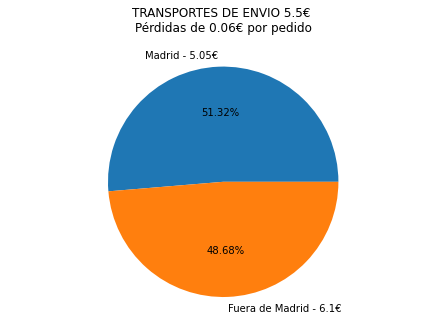

In [127]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
langs = ['Madrid - 5.05€', 'Fuera de Madrid - 6.1€']
students = [51.32,100-51.32]
ax.pie(students, labels = langs,autopct='%1.2f%%')
title= 'TRANSPORTES DE ENVIO 5.5€ \nPérdidas de {}€ por pedido'.format(abs(round(0.5132*(5.5-5.05)+(1-0.5132)*(5.5-6.1),2)))
plt.title(title)
plt.show()

In [128]:
counts=df_ord['email'].replace('',np.nan).dropna().value_counts().reset_index()
counts.columns=['email','counts']

In [129]:
email_counts = pd.merge(counts.reset_index(),
         df_ord[['email','ship_province']],
         on='email',how='left').drop('index',axis=1).drop_duplicates('email')

In [130]:
counts_total = email_counts['counts'].value_counts().sort_values(ascending=False)
counts_perc = (100*email_counts[
                                'counts'
                              ].value_counts().sort_values(
                                                            ascending=False
                                                         )
                               /len(email_counts['counts'])
              ).apply(lambda x:str(round(x,2))+'%')
                      
labels=['un solo pedido','dos pedidos','tres pedidos','cuatro pedidos','cinco pedidos']
pd.DataFrame({'Numero de Pedidos x Cliente':labels,'Nº de Clientes':counts_total,'% total':counts_perc})

,Numero de Pedidos x Cliente,Nº de Clientes,% total
1,un solo pedido,594,88.0%
2,dos pedidos,55,8.15%
3,tres pedidos,17,2.52%
4,cuatro pedidos,7,1.04%
7,cinco pedidos,2,0.3%


Text(0, 0.5, 'counts')

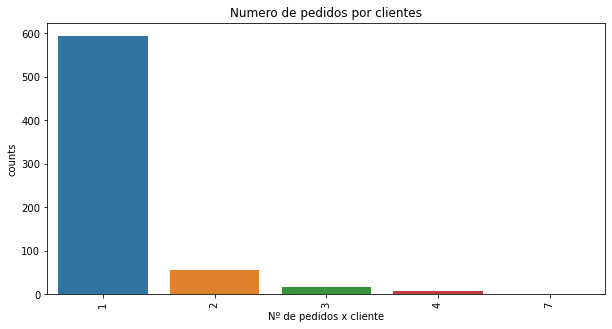

In [131]:
fig = plt.figure(figsize=(10,5))
sns.countplot('counts',data=email_counts.sort_values('counts'))
plt.xticks(rotation=90)
plt.title('Numero de pedidos por clientes')
plt.xlabel('Nº de pedidos x cliente')
plt.ylabel('counts')

### con latitud longitud

In [132]:
df_ord.apply(lambda x: str(x['ship_latitude'])+str(x['ship_longitude']),axis=1
            ).replace('nannan',np.nan).dropna().value_counts().value_counts()


1    620
2     42
3      8
4      2
8      1
dtype: int64

## en cuantas nos comemos el transporte

In [133]:
df_ventas.columns

Index(['latitude', 'country', 'packHidra_unit_price',
       'packContigo_total_price', 'manteca_total_price', 'total_tax',
       'longitude', 'client_gender', 'client_last_name', 'product_movement',
       'order_id', 'accounting_item', 'packContigo_nb', 'total_price',
       'manteca_unit_price', 'id', 'packHidra_nb', 'manteca_nb', 'gateway',
       'origin', 'order_status_url', 'packContigo_unit_price', 'province',
       'close_date', 'client_email', 'balsamo_unit_price', 'balsamo_nb',
       'crema_unit_price', 'creation_date', 'crema_total_price', 'client_name',
       'zip', 'subtotal_price', 'packHidra_total_price', 'crema_nb',
       'balsamo_total_price', 'packBandana_total_price', 'packAbanico_nb',
       'packBandana_nb', 'packAbanico_unit_price', 'bolsa_unit_price',
       'packAbanico_total_price', 'packBandana_unit_price', 'client_adresse',
       'packNavidad_nb', 'bolsa_total_price', 'client_phone',
       'packNavidad_total_price', 'city', 'packNavidad_unit_price', '

54.0
44.0


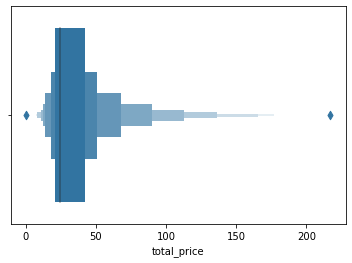

In [134]:
thres = df_ventas['total_price'].quantile(0.99)
sns.boxenplot(x=df_ventas[df_ventas['total_price']<thres]['total_price'])
print(df_ventas['total_price'].quantile(0.90))
print(df_ventas['total_price'].quantile(0.75))
plt.show()

Text(0.5, 1.0, 'Histograma de precios/ingresos de los pedidos\n (sin right_outliers)')

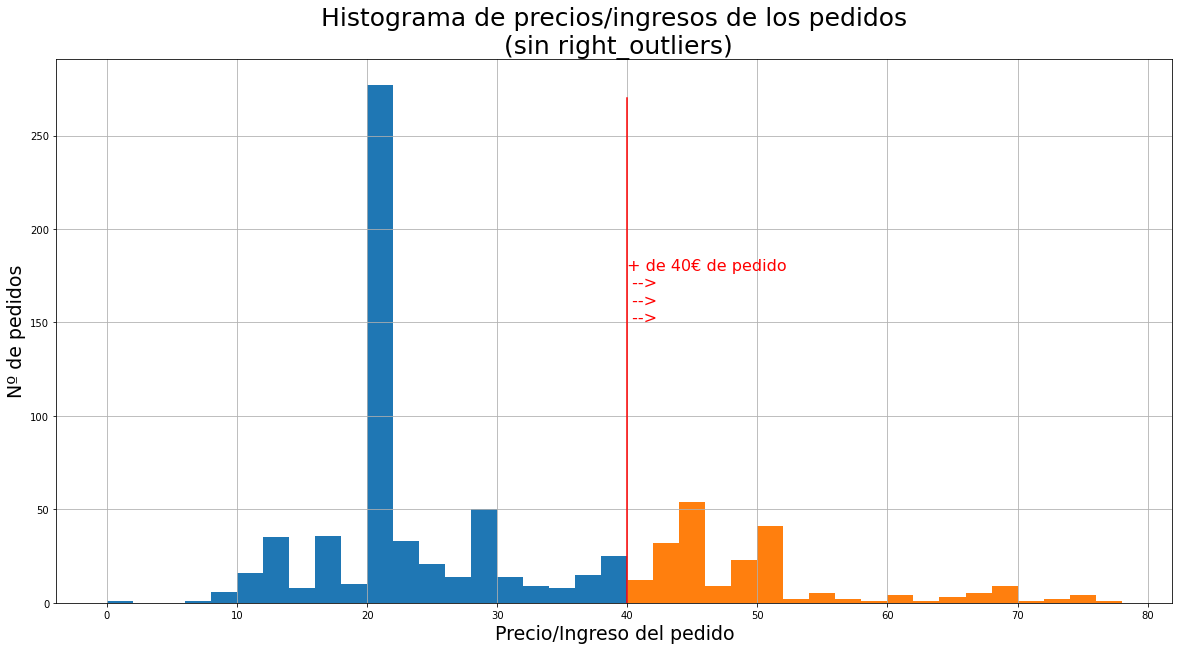

In [135]:
thres = df_ventas['total_price'].quantile(0.98)
#total_price=df_ventas[df_ventas['total_price']<thres]['total_price']
df_ventas[df_ventas['total_price']<40]['total_price'].hist(bins=np.arange(0,41,2),figsize=(20,10))
df_ventas[df_ventas['total_price']>40]['total_price'].hist(bins=np.arange(40,80,2),figsize=(20,10))
plt.xlabel('Precio/Ingreso del pedido',fontsize=19)
plt.ylabel('Nº de pedidos',fontsize=19)
plt.plot(40*np.ones(10),30*np.arange(10),color='r')
plt.text(40,150,'+ de 40€ de pedido\n -->\n -->\n -->',fontsize=16,color='r')
plt.title('Histograma de precios/ingresos de los pedidos\n (sin right_outliers)',fontsize=25)

In [136]:
thres=40
len(df_ventas)
menores = round(len(df_ventas[df_ventas['total_price']<thres]['total_price'])/len(df_ventas),2)
menores

0.67

In [137]:
mayores = round(len(df_ventas[df_ventas['total_price']>=thres]['total_price'])/len(df_ventas),2)
mayores

0.33

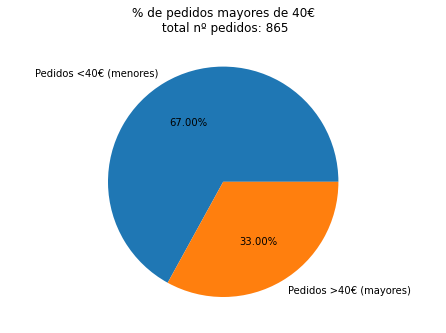

In [138]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
langs = ['Pedidos <40€ (menores)', 'Pedidos >40€ (mayores)']
students = [menores,mayores]
ax.pie(students, labels = langs,autopct='%1.2f%%')
title= '% de pedidos mayores de 40€\n total nº pedidos: {}'.format(len(df_ventas))
plt.title(title)
plt.show()

In [139]:
ventas_cols = df_ventas.columns

In [140]:
nb = [col for col in ventas_cols if 'nb' in col]

In [141]:
df_ventas.fillna(0.0,inplace=True)

In [142]:
df_ventas.apply(lambda x:
                ((str(x['crema_nb'])+'_cre||'
                 )+(str(x['balsamo_nb'])+'_bal||'
                 )+(str(x['manteca_nb'])+'_mant||'
                 )+(str(x['packHidra_nb'])+'_packH||'
                 )+(str(x['packContigo_nb'])+'_packC||'
                 )+(str(x['packNavidad_nb'])+'_packN'
                 )
                 ),axis=1
               ).value_counts()[0:20]

0.0_cre||0.0_bal||0.0_mant||1.0_packH||0.0_packC||0.0_packN    300
0.0_cre||0.0_bal||1.0_mant||0.0_packH||0.0_packC||0.0_packN     55
0.0_cre||0.0_bal||0.0_mant||0.0_packH||0.0_packC||2.0_packN     52
0.0_cre||0.0_bal||0.0_mant||3.0_packH||0.0_packC||0.0_packN     42
0.0_cre||0.0_bal||0.0_mant||0.0_packH||0.0_packC||1.0_packN     40
0.0_cre||0.0_bal||0.0_mant||2.0_packH||0.0_packC||0.0_packN     37
0.0_cre||0.0_bal||2.0_mant||0.0_packH||0.0_packC||0.0_packN     25
0.0_cre||0.0_bal||1.0_mant||2.0_packH||0.0_packC||0.0_packN     18
0.0_cre||0.0_bal||3.0_mant||0.0_packH||0.0_packC||0.0_packN     17
0.0_cre||0.0_bal||1.0_mant||1.0_packH||0.0_packC||0.0_packN     13
0.0_cre||0.0_bal||0.0_mant||4.0_packH||0.0_packC||0.0_packN     11
0.0_cre||0.0_bal||5.0_mant||0.0_packH||0.0_packC||0.0_packN     11
0.0_cre||0.0_bal||6.0_mant||0.0_packH||0.0_packC||0.0_packN     11
0.0_cre||0.0_bal||0.0_mant||0.0_packH||0.0_packC||4.0_packN     10
0.0_cre||0.0_bal||0.0_mant||0.0_packH||0.0_packC||3.0_packN   

In [143]:
df_ventas['subtotal_price']

0      16.00
1      28.00
2      21.00
3      16.00
4      11.00
       ...  
860    38.90
861    21.90
862    12.95
863     8.45
864     6.45
Name: subtotal_price, Length: 865, dtype: float64

Text(0, 0.5, 'precios')

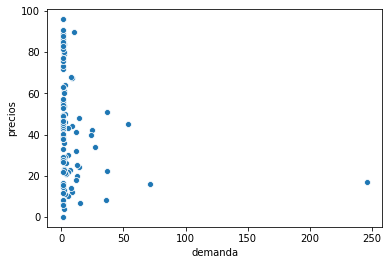

In [144]:
#precios y demanda gráficos
demand_plot = df_ventas[df_ventas['subtotal_price']<100]['subtotal_price'].value_counts().reset_index()
sns.scatterplot(x='subtotal_price',y='index',data=demand_plot)
plt.xlabel('demanda')
plt.ylabel('precios')

## HOW MUCH MONEY DO WE LOOSE

In [145]:
thres = df_ventas['subtotal_price'].quantile(0.97)
print(thres)
total_price=df_ventas[df_ventas['subtotal_price']<thres]['subtotal_price']
print(len(total_price))
total_revenue=total_price.sum()
total_revenue

91.39999999999964
839


23876.85

In [146]:
thres=40
lost_transport=5.56*0.25*len(total_price)
lost_transport

1166.2099999999998

Text(0, 0.5, '€')

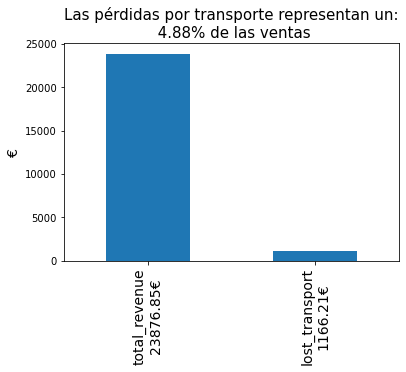

In [147]:
labels=['total_revenue\n{}€'.format(round(total_revenue,2)),
        'lost_transport\n{}€'.format(round(lost_transport,2))
                                  ]
bar_to_plot = pd.DataFrame({'lab':labels,
                            'val':[total_revenue,lost_transport]})
ax = bar_to_plot.plot(x='lab', y='val', kind='bar')
ax.get_legend().remove()
ax.set_title(
    'Las pérdidas por transporte representan un:\n {}% de las ventas'.format(
                            round(100*(lost_transport/total_revenue),2)),
    fontsize=15
        )
ax.set_xlabel('')
plt.xticks(fontsize=14)
ax.set_ylabel('€',fontsize=14)

### comisiones financieras

In [148]:
def comisiones(x):
    gateway = x['gateway']
    if gateway== 'shopify_payments':
        return x['total_price']*0.021+0.25
    elif gateway== 'paypal':
        return x['total_price']*0.019+0.35
    else:
        print('error')
        print(gateway)
    return 0

In [149]:
#comisiones
df_ventas_shop = df_ventas[
                           #(df_ventas['origin'] != 'Contoan') &
                           #(df_ventas['gateway'] != 'shopify_payments')]
                           #(df_ventas['gateway'] != 'paypal')]
                          (df_ventas['origin'] != 'Contoan')]
total_comisiones=df_ventas_shop.apply(lambda x: comisiones(x),axis=1).sum()
total_comisiones

824.75638

In [150]:
total_sin_trans = df_ventas_shop['subtotal_price'].sum()
total_sin_trans

26452.85

In [151]:
100*total_comisiones/total_sin_trans

3.1178356207365185

Text(0, 0.5, '€')

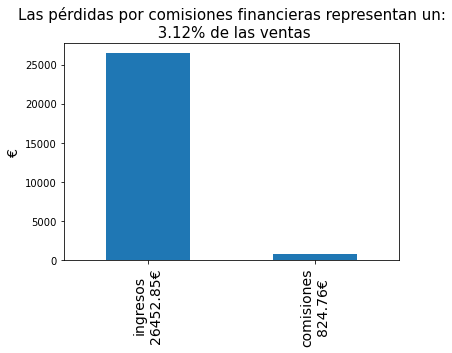

In [152]:
labels=['ingresos\n{}€'.format(round(total_sin_trans,2)),
        'comisiones\n{}€'.format(round(total_comisiones,2))
                                  ]
bar_to_plot = pd.DataFrame({'lab':labels,
                            'val':[total_sin_trans,total_comisiones]})
ax = bar_to_plot.plot(x='lab', y='val', kind='bar')
ax.get_legend().remove()
ax.set_title(
    'Las pérdidas por comisiones financieras representan un:\n {}% de las ventas'.format(
                            round(100*total_comisiones/total_sin_trans,2)),
    fontsize=15
        )
ax.set_xlabel('')
plt.xticks(fontsize=14)
ax.set_ylabel('€',fontsize=14)

Etiquetas (x2)		0.13 €
Envase+envasado+materia prima		1.16 €
Cajas		0.32 €

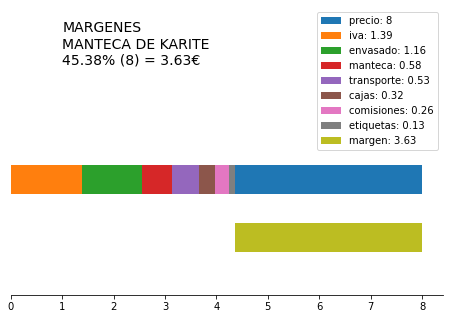

In [153]:
#MANTECAS
fig = plt.figure()
ax = fig.add_axes((1,1,1,1))
precio=8
width=0.1
#comisiones
p1 = ax.barh([1],[precio],width,label='precio: {}'.format(precio))

#IVA
iva=round(precio*(1-1/1.21),2)
p2 = ax.barh([1],[iva],width,left=0,label='iva: {}'.format(iva))

#ENVASADO
envasado=1.16
left=iva
p3 = ax.barh([1],[envasado],width,left=left,label='envasado: {}'.format(envasado))


#COSTE MANTECA
manteca=0.58
left=left+envasado
p3 = ax.barh([1],[manteca],width,left=left,label='manteca: {}'.format(manteca))


#transporte gratuito y pedidos fuera de madrid
transporte=round(precio*0.0586+0.06,2)
left=left+manteca
p4 = ax.barh([1],[transporte],width,left=left,label='transporte: {}'.format(transporte))

#cajas
cajas=0.32
left=left+transporte
p6 = ax.barh([1],[cajas],width,left=left,label='cajas: {}'.format(cajas))

#comisiones
comisiones=round(precio*0.033,2)
left=left+cajas
p5 = ax.barh([1],[comisiones],width,left=left,label='comisiones: {}'.format(comisiones))

#etiquetas
etiquetas=0.13
left=left+comisiones
p7 = ax.barh([1],[etiquetas],width,left=left,label='etiquetas: {}'.format(etiquetas))

#margen
left=left+etiquetas
margen=precio-left
p8 = ax.barh([0.8],[margen],width,left=left,label='margen: {}'.format(margen))

costes_pack1=etiquetas+envasado+manteca

perc_margen = round(100*margen/precio,2)

text='MARGENES\nMANTECA DE KARITE\n{}% (8) = {}€'.format(perc_margen,margen)
plt.text(1,1.4,text,fontsize=14)

plt.ylim(0.6,1.6)
ax.set_yticks([])
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.legend()

### CREMAS

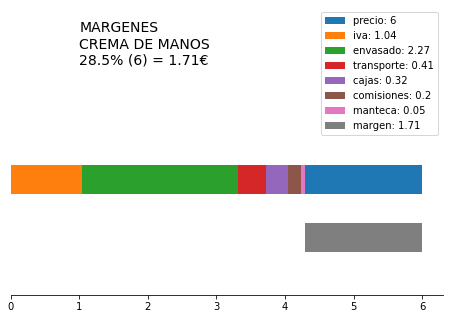

In [154]:
#CREMAS
fig = plt.figure()
ax = fig.add_axes((1,1,1,1))
precio=6
width=0.1
#comisiones
p1 = ax.barh([1],[precio],width,label='precio: {}'.format(precio))

#IVA
iva=round(precio*(1-1/1.21),2)
p2 = ax.barh([1],[iva],width,left=0,label='iva: {}'.format(iva))

#ENVASADO
envasado=2.27
left=iva
p3 = ax.barh([1],[envasado],width,left=left,label='envasado: {}'.format(envasado))
env2=envasado


#transporte gratuito y pedidos fuera de madrid
transporte=round(precio*0.0586+0.06,2)
left=left+envasado
p4 = ax.barh([1],[transporte],width,left=left,label='transporte: {}'.format(transporte))

#cajas
cajas=0.32
left=left+transporte
p6 = ax.barh([1],[cajas],width,left=left,label='cajas: {}'.format(cajas))

#comisiones
comisiones=round(precio*0.033,2)
left=left+cajas
p5 = ax.barh([1],[comisiones],width,left=left,label='comisiones: {}'.format(comisiones))

#COSTE MANTECA
manteca=0.05
left=left+comisiones
p3 = ax.barh([1],[manteca],width,left=left,label='manteca: {}'.format(manteca))

#margen
left=left+manteca
margen=round(precio-left,2)
p8 = ax.barh([0.8],[margen],width,left=left,label='margen: {}'.format(margen))

costes_pack2=envasado+manteca

perc_margen = round(100*margen/precio,2)

text='MARGENES\nCREMA DE MANOS\n{}% (6) = {}€'.format(perc_margen,margen)
plt.text(1,1.4,text,fontsize=14)

plt.ylim(0.6,1.6)
ax.set_yticks([])
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.legend()

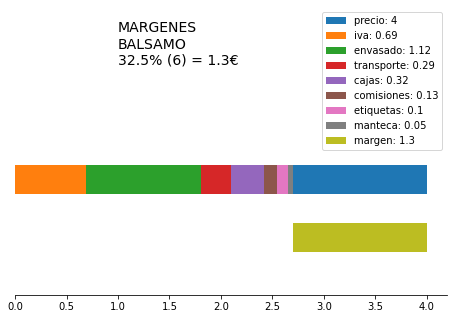

In [155]:
#BALSAMOS
fig = plt.figure()
ax = fig.add_axes((1,1,1,1))
precio=4
width=0.1
#comisiones
p1 = ax.barh([1],[precio],width,label='precio: {}'.format(precio))

#IVA
iva=round(precio*(1-1/1.21),2)
p2 = ax.barh([1],[iva],width,left=0,label='iva: {}'.format(iva))

#ENVASADO
envasado=1.12
left=iva
p3 = ax.barh([1],[envasado],width,left=left,label='envasado: {}'.format(envasado))
env3=envasado


#transporte gratuito y pedidos fuera de madrid
transporte=round(precio*0.0586+0.06,2)
left=left+envasado
p4 = ax.barh([1],[transporte],width,left=left,label='transporte: {}'.format(transporte))

#cajas
cajas=0.32
left=left+transporte
p6 = ax.barh([1],[cajas],width,left=left,label='cajas: {}'.format(cajas))

#comisiones
comisiones=round(precio*0.033,2)
left=left+cajas
p5 = ax.barh([1],[comisiones],width,left=left,label='comisiones: {}'.format(comisiones))

#etiquetas
etiquetas=0.1
left=left+comisiones
p7 = ax.barh([1],[etiquetas],width,left=left,label='etiquetas: {}'.format(etiquetas))

#COSTE MANTECA
manteca=0.05
left=left+etiquetas
p3 = ax.barh([1],[manteca],width,left=left,label='manteca: {}'.format(manteca))

#margen
left=left+manteca
margen=round(precio-left,2)
p8 = ax.barh([0.8],[margen],width,left=left,label='margen: {}'.format(margen))

costes_pack3=etiquetas+envasado+manteca

perc_margen = round(100*margen/precio,2)

text='MARGENES\nBALSAMO\n{}% (6) = {}€'.format(perc_margen,margen)
plt.text(1,1.4,text,fontsize=14)

plt.ylim(0.6,1.6)
ax.set_yticks([])
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.legend()

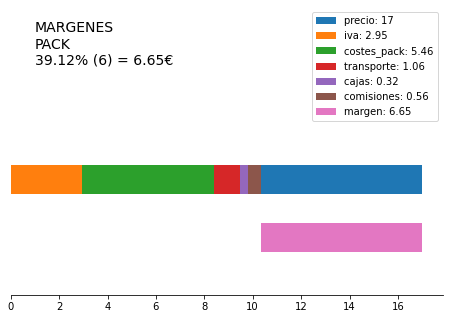

In [156]:
#PACK + HIDRATADA
fig = plt.figure()
ax = fig.add_axes((1,1,1,1))
precio=17
width=0.1
#precio
p1 = ax.barh([1],[precio],width,label='precio: {}'.format(precio))

#IVA
iva=round(precio*(1-1/1.21),2)
p2 = ax.barh([1],[iva],width,left=0,label='iva: {}'.format(iva))

#ENVASADO Y MANTECA
costes_pack=costes_pack1+costes_pack2+costes_pack3
left=iva
p3 = ax.barh([1],[costes_pack],width,left=left,label='costes_pack: {}'.format(costes_pack))


#transporte gratuito y pedidos fuera de madrid
transporte=round(precio*0.0586+0.06,2)
left=left+costes_pack
p4 = ax.barh([1],[transporte],width,left=left,label='transporte: {}'.format(transporte))

#cajas
cajas=0.32
left=left+transporte
p6 = ax.barh([1],[cajas],width,left=left,label='cajas: {}'.format(cajas))

#comisiones
comisiones=round(precio*0.033,2)
left=left+cajas
p5 = ax.barh([1],[comisiones],width,left=left,label='comisiones: {}'.format(comisiones))

#margen
left=left+comisiones
margen=round(precio-left,2)
p8 = ax.barh([0.8],[margen],width,left=left,label='margen: {}'.format(margen))

costes_pack3=etiquetas+envasado+manteca

perc_margen = round(100*margen/precio,2)

text='MARGENES\nPACK\n{}% (6) = {}€'.format(perc_margen,margen)
plt.text(1,1.4,text,fontsize=14)

plt.ylim(0.6,1.6)
ax.set_yticks([])
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.legend()

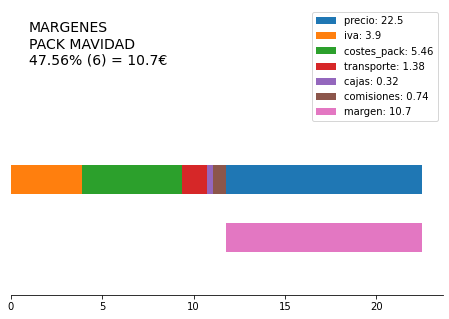

In [157]:
#PACK + HIDRATADA
fig = plt.figure()
ax = fig.add_axes((1,1,1,1))
precio=22.5
width=0.1
#precio
p1 = ax.barh([1],[precio],width,label='precio: {}'.format(precio))

#IVA
iva=round(precio*(1-1/1.21),2)
p2 = ax.barh([1],[iva],width,left=0,label='iva: {}'.format(iva))

#ENVASADO Y MANTECA
costes_pack=costes_pack1+costes_pack2+costes_pack3
left=iva
p3 = ax.barh([1],[costes_pack],width,left=left,label='costes_pack: {}'.format(costes_pack))


#transporte gratuito y pedidos fuera de madrid
transporte=round(precio*0.0586+0.06,2)
left=left+costes_pack
p4 = ax.barh([1],[transporte],width,left=left,label='transporte: {}'.format(transporte))

#cajas
cajas=0.32
left=left+transporte
p6 = ax.barh([1],[cajas],width,left=left,label='cajas: {}'.format(cajas))

#comisiones
comisiones=round(precio*0.033,2)
left=left+cajas
p5 = ax.barh([1],[comisiones],width,left=left,label='comisiones: {}'.format(comisiones))

#margen
left=left+comisiones
margen=round(precio-left,2)
p8 = ax.barh([0.8],[margen],width,left=left,label='margen: {}'.format(margen))

costes_pack3=etiquetas+envasado+manteca

perc_margen = round(100*margen/precio,2)

text='MARGENES\nPACK MAVIDAD\n{}% (6) = {}€'.format(perc_margen,margen)
plt.text(1,1.4,text,fontsize=14)

plt.ylim(0.6,1.6)
ax.set_yticks([])
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.legend()

In [158]:
total=df_ventas.apply(lambda x:
                ((str(x['crema_nb'])+'_cre||'
                 )+(str(x['balsamo_nb'])+'_bal||'
                 )+(str(x['manteca_nb'])+'_mant||'
                 )+(str(x['packHidra_nb'])+'_packH||'
                 )+(str(x['packContigo_nb'])+'_packC'
                 )
                 ),axis=1
               ).value_counts()[0:10].sum()
print(total)
sales_dist=df_ventas.apply(lambda x:
                ((str(x['crema_nb'])+'_cre||'
                 )+(str(x['balsamo_nb'])+'_bal||'
                 )+(str(x['manteca_nb'])+'_mant||'
                 )+(str(x['packHidra_nb'])+'_packH||'
                 )+(str(x['packContigo_nb'])+'_packC'
                 )
                 ),axis=1
               ).value_counts()[0:10]/total
sales_dist

649


0.0_cre||0.0_bal||0.0_mant||1.0_packH||0.0_packC    0.463790
0.0_cre||0.0_bal||0.0_mant||0.0_packH||0.0_packC    0.192604
0.0_cre||0.0_bal||1.0_mant||0.0_packH||0.0_packC    0.086287
0.0_cre||0.0_bal||0.0_mant||3.0_packH||0.0_packC    0.064715
0.0_cre||0.0_bal||0.0_mant||2.0_packH||0.0_packC    0.060092
0.0_cre||0.0_bal||2.0_mant||0.0_packH||0.0_packC    0.038521
0.0_cre||0.0_bal||1.0_mant||2.0_packH||0.0_packC    0.027735
0.0_cre||0.0_bal||3.0_mant||0.0_packH||0.0_packC    0.027735
0.0_cre||0.0_bal||1.0_mant||1.0_packH||0.0_packC    0.020031
0.0_cre||0.0_bal||5.0_mant||0.0_packH||0.0_packC    0.018490
dtype: float64

MANTECA: 45.4%
CREMA: 28.5%
BALSAMO: 32.5%
PACK: 39.1%

In [159]:
labels = ['1pack','1manteca','3packs','2packs','2mantecas','1mateca_2packs','1mateca_1packs',
         '3matecas','5matecas','4packs']

marg = [0.391,0.454,0.391,0.391,0.454,0.412,0.4225,0.454,0.454,0.391] 

mantecas = [0,1,0,0,2,1,1,3,5,0]
packs = [1,0,3,2,0,2,1,0,0,4]

margenes = pd.DataFrame({'ventas mas comunes':labels,
                         'mantecas':mantecas,
                         'packs':packs,
                         '% recurrencia':sales_dist,
                         'margenes':marg}).reset_index(drop=True)
margenes

,ventas mas comunes,mantecas,packs,% recurrencia,margenes
0,1pack,0,1,0.463790,0.3910
1,1manteca,1,0,0.192604,0.4540
2,3packs,0,3,0.086287,0.3910
3,2packs,0,2,0.064715,0.3910
4,2mantecas,2,0,0.060092,0.4540
5,1mateca_2packs,1,2,0.038521,0.4120
6,1mateca_1packs,1,1,0.027735,0.4225
7,3matecas,3,0,0.027735,0.4540
8,5matecas,5,0,0.020031,0.4540
9,4packs,0,4,0.018490,0.3910


In [160]:
margenes['precio']=margenes['mantecas']*10+margenes['packs']*18

In [161]:
(margenes['margenes']*margenes['% recurrencia']).sum()/margenes['% recurrencia'].sum()

0.41161171032357474

# OBJETIVO DE VENTAS

In [162]:
# COSTES FIJOS EN NIKKI 600€
600/0.40362210526315795

1486.5389981770336

In [163]:
1486*12

17832

In [164]:
margenes['ventas']=margenes['% recurrencia']*1500

In [165]:
margenes['beneficios']=margenes['ventas']*margenes['margenes']

In [166]:
margenes['packs_total'] = margenes['packs']*margenes['ventas']/(margenes['precio'])

In [167]:
margenes['mantecas_total'] =margenes['mantecas']*margenes['ventas']/(margenes['precio'])

In [168]:
margenes=margenes.replace(np.nan,0)

In [169]:
margenes['mantecas_total'] = margenes['mantecas_total']
margenes['packs_total'] = margenes['packs_total']

In [170]:
margenes['% recurrencia']=margenes['% recurrencia'].apply(lambda x:str(round(100*x,2))+'%')

In [171]:
margenes

,ventas mas comunes,mantecas,packs,% recurrencia,margenes,precio,ventas,beneficios,packs_total,mantecas_total
0,1pack,0,1,46.38%,0.3910,18,695.685670,272.013097,38.649204,0.000000
1,1manteca,1,0,19.26%,0.4540,10,288.906009,131.163328,0.000000,28.890601
2,3packs,0,3,8.63%,0.3910,54,129.429892,50.607088,7.190550,0.000000
3,2packs,0,2,6.47%,0.3910,36,97.072419,37.955316,5.392912,0.000000
4,2mantecas,2,0,6.01%,0.4540,20,90.138675,40.922958,0.000000,9.013867
5,1mateca_2packs,1,2,3.85%,0.4120,46,57.781202,23.805855,2.512226,1.256113
6,1mateca_1packs,1,1,2.77%,0.4225,28,41.602465,17.577042,1.485802,1.485802
7,3matecas,3,0,2.77%,0.4540,30,41.602465,18.887519,0.000000,4.160247
8,5matecas,5,0,2.0%,0.4540,50,30.046225,13.640986,0.000000,3.004622
9,4packs,0,4,1.85%,0.3910,72,27.734977,10.844376,1.540832,0.000000


## 18€ packs y 10€ mantecas

In [172]:
print('Estadisticas mensuales')
margenes[['mantecas_total','packs_total','ventas','beneficios']].sum()

Estadisticas mensuales


mantecas_total      47.811253
packs_total         56.771526
ventas            1500.000000
beneficios         617.417565
dtype: float64

In [173]:
print('Estadisticas diarias')
margenes[['mantecas_total','packs_total','ventas','beneficios']].sum()/30

Estadisticas diarias


mantecas_total     1.593708
packs_total        1.892384
ventas            50.000000
beneficios        20.580586
dtype: float64